In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, islice
from multitools import make_pos_def, gamma_GC

In [2]:
# parameters # four variables: 3 objectives, 1 constraints
nobj = 3
ncon = 1  # to simplify my coding i 
r = np.array([      
    [1.0, 0.4, -0.5, 0.3],
    [0.4, 1.0, 0.5, 0.4],
    [-0.5, 0.5, 1.0, 0.2],
    [0.3, 0.4, 0.2, 1.0],
])

shape, scale = [3.0, 3.0, 1.0, 8.0], [1.0, 1.5, 3.0,1.0]

In [3]:
n = 100
samples = gamma_GC(r, n, shape, scale)

In [4]:
def cleanupsamples(samples,nobj,precision=1): 
    samples = np.round(samples,precision)
    c,i = np.unique(samples[:,:nobj], axis=0, return_index=True)
    newsamples = samples[i,:] #note - these have been sorted into increasing magnitude. 
    if precision==0:
        newsamples = np.array(newsamples, dtype='int8')
         
    return newsamples

In [5]:
samples = cleanupsamples(samples,nobj,precision=0)
print(f"Number of unique samples: {samples.shape[0]}")

Number of unique samples: 74


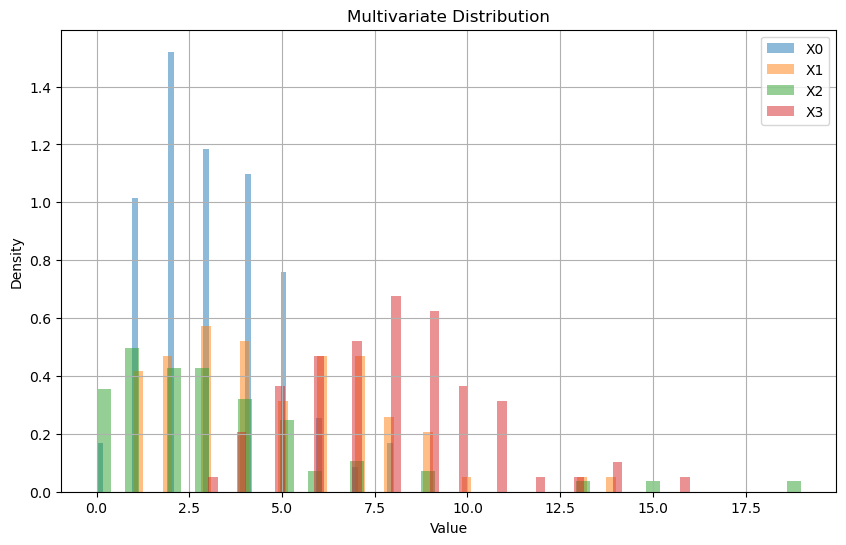

In [6]:
n_dims = samples.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_dims):
    plt.hist(samples[:, i], bins=50, density=True, alpha=0.5, label=f"X{i}")

plt.title("Multivariate Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.xlim(0, 6)
plt.legend()
plt.grid(True)
plt.show()

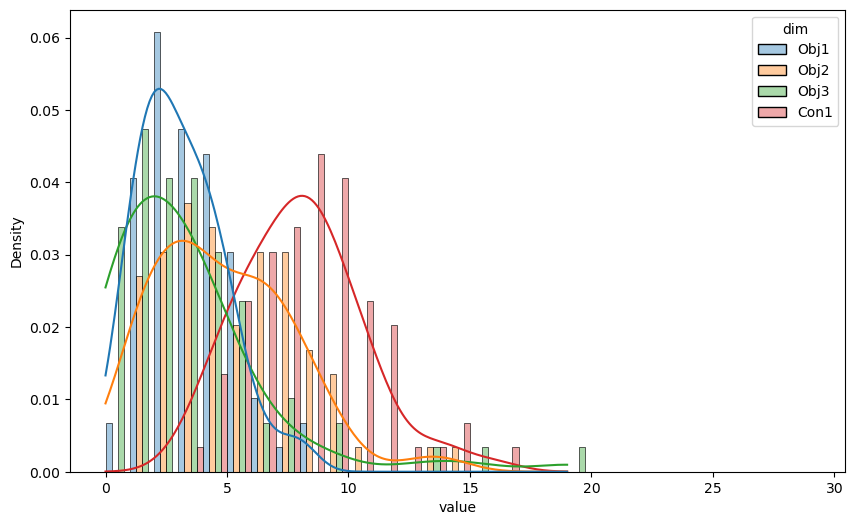

In [7]:
# Convert to DataFrame and melt to long format for seaborn
df = pd.DataFrame(samples, columns=['Obj1','Obj2','Obj3','Con1'])
df_long = df.melt(var_name="dim", value_name="value")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_long,
    x="value",
    hue="dim",
    bins=np.arange(0, 30, 1),
    stat="density",
    element="bars",
    fill=True,
    common_bins = True,
    multiple="dodge",
    alpha=0.4,
    kde=True 
)
plt.show()



In [8]:
def non_dominated(objectives):
    n_solutions = objectives.shape[0]
    non_dominated = np.ones(n_solutions, dtype=bool)
    for i in range(n_solutions):
        for j in range(n_solutions):
            if i == j:
                continue
            if np.all(objectives[j, :] >= objectives[i, :]) and \
                np.any(objectives[j, :] > objectives[i, :]):
                non_dominated[i] = False
                break

    return non_dominated

In [9]:
def get_objectives(samples, indices,nobj):
    objectives = np.zeros((indices.shape[0], nobj),dtype='int16')
    for j in range(indices.shape[0]):
        objectives[j,:] = np.sum(samples[indices[j],:nobj],axis=0,dtype='int16')
    return objectives
def get_constraints(samples, indices,nobj,ncon):
    constraints = np.zeros((indices.shape[0],ncon),dtype='int16')
    for j in range(indices.shape[0]):
        constraints[j,:] = np.sum(samples[indices[j],nobj:],axis=0,dtype='int16')
    constraints = np.squeeze(constraints)
    return constraints

In [10]:
samples = np.flipud(np.sort(samples, axis=0))

In [11]:
ksize = 6 
n_items = samples.shape[0]
kconstraint = int(shape[-1]*scale[-1]*ksize)
print(f"Knapsack constraint: {kconstraint}")
y = np.array(range(samples.shape[0]))
items = np.array(list(islice(combinations(y,ksize),0,4000000)))   
constraints = get_constraints(samples, items,nobj,ncon)
print(np.min(constraints))
items = items[constraints < kconstraint,:]
objectives = get_objectives(samples, items,nobj)


Knapsack constraint: 48
43


In [12]:
nk = objectives.shape[0]
non_dominated_mask = np.ones(nk, dtype=bool)
non_dominated_items = list()
print(nk)
while nk > 1: 
    k_dominates_mask = np.ones(nk, dtype=bool) 
    k_dominates_mask[1:] = np.all(objectives[1:,:]-objectives[0,:] <= 0, axis = 1) & np.any(objectives[1:,:]-objectives[0,:] < 0, axis = 1)
    items = items[~k_dominates_mask,:]
    objectives = objectives[~k_dominates_mask,:]
    nk = objectives.shape[0]
    print(nk)
    print(nk)
    if nk < 2:
        break
    if np.any(np.all(objectives[1:,:] - objectives[0,:] >= 0, axis = 1) & np.any(objectives[1:,:] - objectives[0,:] > 0, axis = 1)):
        continue
    else:
        print(items[0,:])
        non_dominated_items.append(items[0,:])
    items = items[1:,:]
    objectives = objectives[1:,:]
    nk = objectives.shape[0] 



3119
15
15
[ 0  1 53 69 71 73]
13
13
[ 0  1 54 69 70 73]
11
11
[ 0  1 54 70 71 73]
9
9
[ 0  1 55 69 71 73]
7
7
[ 0  1 56 69 70 73]
5
5
[ 0  1 56 70 71 73]
2
2
[ 0  1 62 63 70 73]
